*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Regression Linéaire Multiple</div>

*******

### Tables des matières<a class="anchor" id="retour"></a> 

* [Librairies Python](#Librairie)
* [Présentation et rappels statistiques](#Présentation)
* [Régression avec toutes les variables ](#Partie_1)
* [Prévision](#Partie_2)
* [Calcul des points leviers ](#Partie_3)
* [Standardisation des erreurs](#Partie_4)
* [Distance de Cook ](#Partie_5)
* [Collinéarité](#Partie_6)
* [Homoscédasticité des résidus](#Partie_7)
* [Normalité des résidus ](#Partie_8)
* [Backward Selection](#Partie_9)

## Librairies Python  <a class="anchor" id="Librairie"></a> 

In [1]:
# Nous importons les librairies nécessaires à l'étude

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functions import *

# Style des graphes seaborn
sns.set_theme(style="whitegrid")

## Présentation & rappels statistiques  <a class="anchor" id="Présentation"></a> 

>Ce cours est inspiré du cours sur les régressions multiples de OpenClassrooms

>Cette étude cherche à illustrer l'utilisation de la régression multiple à travers un exemple :      
La quatité d'Ozone expliquée par des variables comme la température à différents moments de la journée ou le niveau d'Ozone de la veille.

### Nous cherchons à modéliser :      
### <font color='#8333ff'> $$y=\beta_{0}+\beta_{1}X_{1}+\beta_{2}X_{2}+...+\beta_{p}X_{p}+\varepsilon$$

### Sous forme matricielle :      
## <font color='#8333ff'> $$\mathbb{Y}=\mathbb{X} \beta + \varepsilon$$

#### Nous conservons les hypothèses de la régression simple      
>$\mathbb{E}(\varepsilon{i})=0$  $\;\;\;\;\;\;$ $\;\;\;\;\;\;$ Elles sont centrées autour de 0      
$Var(\varepsilon{i})=\sigma^2$ $\;\;\;\;\;\;$  $\;$ Leur variance, inconnue,est constante et égale à $\sigma^2$     
$Cov(\varepsilon{i},\varepsilon{j})=0$ $\;\;\;\;\;\;$  Si  $i \neq j$ 

### La solution :     
###   $\;\;\;\;\;\;$ $$\hat{\beta}=(\mathbb{X}^t\mathbb{X})^{-1}\mathbb{X}^t\mathbb{Y}  $$    

### Analyse de la Variance

|$$SCT$$|$$SCE$$|$$SCR$$|
|----|------|------|
|$$\sum_{i=1}^{n}(y_{i}−\bar{y})^2 $$ |$$\sum_{i=1}^{n}(\hat{y_{i}}−\bar{y})^2 $$|$$\sum_{i=1}^{n}(y_{i}−\hat{y_{i}})^2 $$|


###  $\;\;\;\;\;\;$ $SCT=SCE+SCR$
###  $\;\;\;\;\;\;$ $R^2=\frac {SCE}{SCT}$

###  $\;\;\;\;\;\;$ $R^{2}_{ajus}=1-\frac {n}{n-p}(1-R^2)$

****
### Les résidus      
#### La différence entre la valeur observée  et son estimation
####  $\;\;\;\;\;\;$ $e_{i}=y_{i}-\bar{y} $ $\;\;\;\;\;\;$       
#### Le résidu $e_{i}$ est une estimation du bruit $\epsilon_{i}$
####  $\;\;\;\;\;\;$ $\varepsilon{i}=y_{i}-{\beta_{0}} - {\beta_{1}}x -{\beta_{2}}x-....-{\beta_{p}}x  $ $\;\;\;\;\;\;$
***

***
#### Nous posons comme hypothèse
### $$\varepsilon \sim \mathcal{N}(\mu,\sigma^{2})$$
#### Sachant que $\;\;\;\;\;\;$ $\sum_{i=1}^{n}e_{i}=0$ $\;\;\;\;\;\;$  Nous avons
### $$\varepsilon \sim \mathcal{N}(0,\sigma^{2})$$
***

Text(0.5, 1.0, 'Loi Normale Centrée-Reduite')

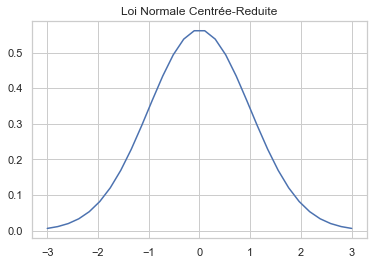

In [2]:
# Pour rappel, un exemple de la fonction de densité d'une loi normale centrée réduite
x = np.linspace(-3, 3,30)
y=(np.exp((-x**2)/2)) / (np.sqrt(np.pi))
plt.plot(x,y,'b')
plt.title("Loi Normale Centrée-Reduite")

In [3]:
df=pd.read_csv('ozone.csv',sep=";")
df

,obs,maxO3,T9,T12,T15,Ne9,Ne12,Ne15,Vx9,Vx12,Vx15,maxO3v,vent,pluie
0,601,87,15.6,18.5,18.4,4,4,8,0.6946,-1.7101,-0.6946,84,Nord,Sec
1,602,82,17.0,18.4,17.7,5,5,7,-4.3301,-4.0000,-3.0000,87,Nord,Sec
2,603,92,15.3,17.6,19.5,2,5,4,2.9544,1.8794,0.5209,82,Est,Sec
3,604,114,16.2,19.7,22.5,1,1,0,0.9848,0.3473,-0.1736,92,Nord,Sec
4,605,94,17.4,20.5,20.4,8,8,7,-0.5000,-2.9544,-4.3301,114,Ouest,Sec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,925,84,13.3,17.7,17.8,3,5,6,0.0000,-1.0000,-1.2856,76,Sud,Sec
108,927,77,16.2,20.8,22.1,6,5,5,-0.6946,-2.0000,-1.3681,71,Sud,Pluie
109,928,99,16.9,23.0,22.6,6,4,7,1.5000,0.8682,0.8682,77,Sud,Sec
110,929,83,16.9,19.8,22.1,6,5,3,-4.0000,-3.7588,-4.0000,99,Ouest,Pluie


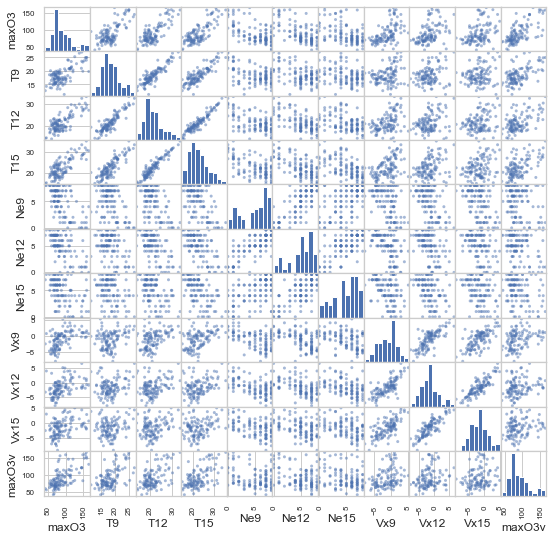

In [4]:
# Scatter plot matrix se fait une idée des liaisons des variables explicatives (exogène)
df_sm=df[['maxO3','T9','T12','T15','Ne9','Ne12','Ne15','Vx9','Vx12','Vx15','maxO3v']]
pd.plotting.scatter_matrix(df_sm,figsize=(9,9))
plt.show()

***
[<font color=blue> Retour à la Table Des Matières](#retour)

****

### Régression avec toutes les variables  <a class="anchor" id="Partie_1"></a> 

In [5]:
reg_multiple=smf.ols('maxO3 ~ T9 + T12 + T15 + Ne9 + Ne12 + Ne15 + Vx9 + Vx12 + Vx15 + maxO3v',data=df).fit()
print(reg_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                  maxO3   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     32.67
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           2.55e-27
Time:                        16:50:43   Log-Likelihood:                -451.55
No. Observations:                 112   AIC:                             925.1
Df Residuals:                     101   BIC:                             955.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2444     13.472      0.909      0.3

***
>Nous retirons du modèle les variables non-significatives par ordre de non-significativité, soit celles qui ont la p-value la plus grande:    
ne15 à une p-value de 0,855    
Vx12 à une p-value de 0.976    
Vx15 à une p-value de 0.649 
***

In [6]:
reg_multiple=smf.ols('maxO3 ~ T9 + T12 + T15 + Ne9 + Ne12 + Vx9 + maxO3v',data=df).fit()
print(reg_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                  maxO3   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     47.81
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.03e-29
Time:                        16:50:43   Log-Likelihood:                -451.77
No. Observations:                 112   AIC:                             919.5
Df Residuals:                     104   BIC:                             941.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.0182     12.803      1.095      0.2

***
>Nous retirons maintenant 
Ne12 et T9

In [7]:
reg_multiple=smf.ols('maxO3 ~ T12 + T15 + Ne9 + Vx9 + maxO3v',data=df).fit()
print(reg_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                  maxO3   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     68.14
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.57e-31
Time:                        16:50:43   Log-Likelihood:                -451.82
No. Observations:                 112   AIC:                             915.6
Df Residuals:                     106   BIC:                             932.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1394     11.093      1.094      0.2

***
>Nous retirons maintenant      
T15

In [8]:
reg_multiple=smf.ols('maxO3 ~ T12 + Ne9 + Vx9 + maxO3v',data=df).fit()
print(reg_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                  maxO3   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     85.75
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.76e-32
Time:                        16:50:43   Log-Likelihood:                -451.93
No. Observations:                 112   AIC:                             913.9
Df Residuals:                     107   BIC:                             927.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6313     11.001      1.148      0.2

***
Maintenant toutes les variables sont significatives et le modèle a encore un $R^2$ à 0.75
***

### Prévision   <a class="anchor" id="Partie_2"></a> 

***
Si nous voulons prévoir:      
15 degrés le midi & Ne9 = 5 & maxO3v = 120  & Vx9 = 0.7
***

In [34]:
a_prevoir = pd.DataFrame({'T12': 15, 'Ne9': 2, 'Vx9':1.3, 'maxO3v': 100}, index=[0])
maxO3_prev = reg_multiple.predict(a_prevoir)
print(round(maxO3_prev[0], 2))

86.23


In [25]:
prevision

,T12,Vx9,Ne9,maxO3v
0,15,0.7,2,100


### Calcul des leviers   <a class="anchor" id="Partie_3"></a> 

>$\alpha=5\%$     
$n$   
$p$

In [10]:
alpha=0.05
n=df.shape[0]
p=4

>Nous allons analyser les valeurs atypiques ou abérantes du modèle.   
>Le seuil du levier est donné par la formule

### $$\frac {2p}{n}$$    


In [11]:
analyses=pd.DataFrame({'obs':np.arange(1,n+1)})

In [12]:
analyses['levier'] = reg_multiple.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

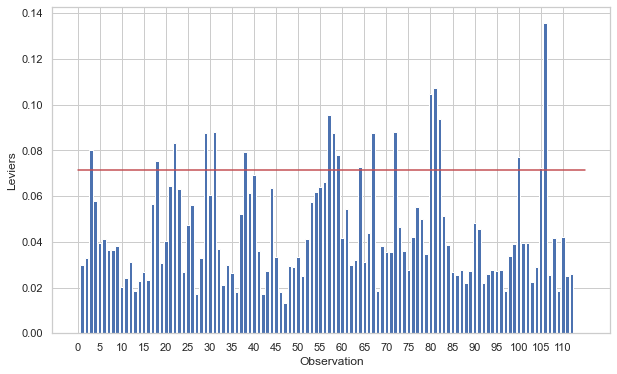

In [13]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 115], [seuil_levier, seuil_levier], color='r')
plt.show()

In [14]:
# Nous reccupèrons les obs pour lesquelles les valeurs sont supérieures au seuil
analyses.loc[analyses['levier']>seuil_levier, : ]

,obs,levier
2,3,0.080406
17,18,0.075204
21,22,0.083399
28,29,0.087834
30,31,0.088063
37,38,0.079451
56,57,0.095383
57,58,0.087436
58,59,0.077910
63,64,0.072827


***
[<font color=blue> Retour à la Table Des Matières](#retour)

****

### Standardisation des erreurs   <a class="anchor" id="Partie_4"></a> 

In [15]:
# Nous créons une colonne avec les erreurs normalisées (studentisées)
analyses['rstudent'] = reg_multiple.get_influence().resid_studentized_internal

# Nous récupérons le seuil à 5%, 1.96 comme les erreurs suivent une loi normale standardisée (0,1)
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

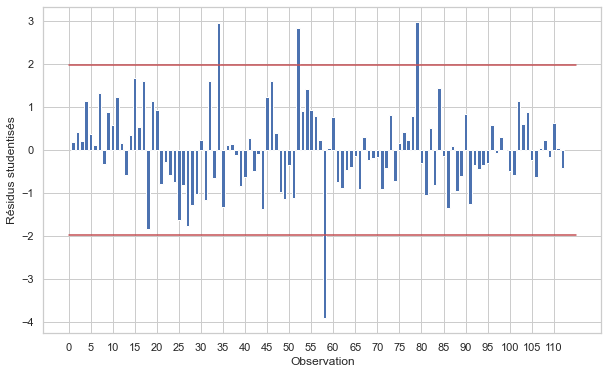

In [16]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 115], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 115], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

***
### Distance de Cook & Représentation des points leviers   <a class="anchor" id="Partie_5"></a> 

>Méthode permettant de mettre en évidence les observations abérentes
***

In [17]:
# Nous récupérons un DF contenant la distance de Cook
influence = reg_multiple.get_influence().summary_frame()
influence

,dfb_Intercept,dfb_T12,dfb_Ne9,dfb_Vx9,dfb_maxO3v,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.026018,-0.022333,-0.011578,0.015177,0.002917,0.000217,0.187890,0.029872,0.032970,0.187041,0.032821
1,0.035109,-0.036531,-0.039242,-0.051802,0.025411,0.001218,0.422354,0.033011,0.078036,0.420727,0.077735
2,0.052144,-0.043460,-0.029991,0.032305,0.004047,0.000780,0.211229,0.080406,0.062460,0.210283,0.062180
3,0.234954,-0.191695,-0.219699,0.038282,0.053476,0.015969,1.141618,0.057728,0.282571,1.143254,0.282976
4,-0.019341,-0.005580,0.048316,0.025855,0.033232,0.001102,0.366153,0.039492,0.074245,0.364667,0.073944
...,...,...,...,...,...,...,...,...,...,...,...
107,0.042102,-0.033362,-0.028765,0.009209,0.001566,0.000425,0.220628,0.041871,0.046122,0.219644,0.045916
108,-0.000041,-0.006349,-0.009875,-0.009484,0.013385,0.000107,-0.167798,0.018712,-0.023171,-0.167034,-0.023066
109,-0.032690,0.058877,0.079331,0.089787,-0.068697,0.003498,0.629595,0.042259,0.132250,0.627810,0.131875
110,0.000709,-0.002303,-0.001275,-0.005791,0.004350,0.000016,0.056084,0.025101,0.008999,0.055822,0.008957


In [18]:
# Nous récupérons la colonne contenant la distance de Cook, et nous l'ajoutons au DF analyses 
analyses['dcooks'] = influence['cooks_d']

# Seuil classique de la distance de Cook
seuil_dcook = 4/(n-p)

analyses

,obs,levier,rstudent,dcooks
0,1,0.029872,0.187890,0.000217
1,2,0.033011,0.422354,0.001218
2,3,0.080406,0.211229,0.000780
3,4,0.057728,1.141618,0.015969
4,5,0.039492,0.366153,0.001102
...,...,...,...,...
107,108,0.041871,0.220628,0.000425
108,109,0.018712,-0.167798,0.000107
109,110,0.042259,0.629595,0.003498
110,111,0.025101,0.056084,0.000016


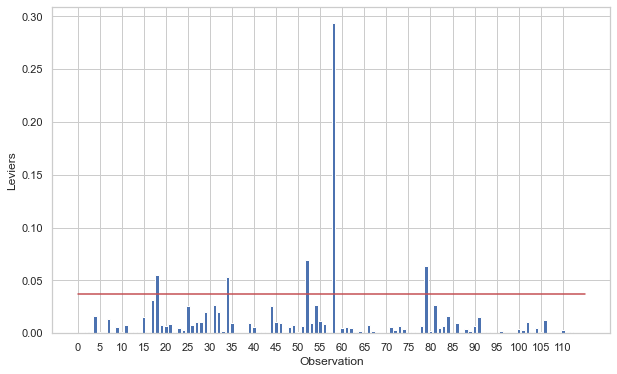

In [19]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 115], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [20]:
# Si nous voulons retirer les points abérents
# analyses=analyses.loc[analyses['dcooks']<seuil_dcook]

***
### Collinéarité entre les variables    <a class="anchor" id="Partie_6"></a> 

>Nous vérifions l'absence de collinéarité entre les variables

In [21]:
# Pour détecter la multicollinéarité
variables = reg_multiple.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[2.0837321036083365, 1.74198554743101, 1.423550202886703, 1.517556958912601]

>Dans la litérature statistique, nous donnons comme seuil 5 ou 10, à ne pas dépasser.    
Ici, il n'y a pas du tout de collinéarité entre les variables. 

***
### Homoscédasticité des résidus   <a class="anchor" id="Partie_7"></a> 


>Nous pouvons également tester l’homoscédasticité, c'est-à-dire la constance de la variance des résidus :
****

In [22]:
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(reg_multiple.resid, variables)
print('p value test Breusch Pagan:', round(pval,4))

p value test Breusch Pagan: 0.0994


#### Interprétation
>La p-valeur ici n'est pas inférieure à $5$%,      
on ne rejette pas l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

### Normalité des résidus      <a class="anchor" id="Partie_8"></a> 


>Si l'on veut tester la normalité des résidus, on peut faire un test de **Shapiro-Wilk**.

In [23]:
shapiro(reg_multiple.resid)

ShapiroResult(statistic=0.965890645980835, pvalue=0.005816894583404064)

>Ici, l'hypothèse de normalité est remise en cause (p-value = 0.003 < 0.05).
>
>Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.
>
>Nous aurions pu aussi sélectionner automatiquement un modèle avec l'ensemble des variables à disposition :variables météo et pic d'ozone de la veille


### Backward Selection     <a class="anchor" id="Partie_9"></a> 

***
>Recherche pas à pas méthode descendante :      
Nous commençons avec toutes les variables et par itération le modèle enlève les variables les moins pertinantes
***

In [24]:
columns = ['maxO3','T9','T12','T15','Ne9','Ne12','Ne15','maxO3v']
reg_backward = backward_selected(df[columns], 'maxO3')

_______________________________
maxO3 ~ Ne12 + T15 + T12 + Ne15 + maxO3v + Ne9 + T9 + 1
remove Ne15 (p-value : 0.928 )

_______________________________
maxO3 ~ Ne12 + T15 + T12 + maxO3v + Ne9 + T9 + 1
remove Ne12 (p-value : 0.787 )

_______________________________
maxO3 ~ T15 + T12 + maxO3v + Ne9 + T9 + 1
remove T15 (p-value : 0.481 )

_______________________________
maxO3 ~ T12 + maxO3v + Ne9 + T9 + 1
remove T9 (p-value : 0.466 )

_______________________________
maxO3 ~ T12 + maxO3v + Ne9 + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:                  maxO3   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     109.1
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.46e-32
Time:                        16:50:45   Log-Likelihood:                -454.30
No. O

***
[<font color=blue> Retour à la Table Des Matières](#retour)

****